This validation case reproduces H absorption curves for Ti at different temperatures obtained by [Y. Hirooka et al.](https://www.sciencedirect.com/science/article/abs/pii/0022311581905663). 

Absorption experiments were performed in the vacuum chamber at the base pressure of $1.3\times10^4$ Pa with $10\times13\times1\,\mathrm{mm}^{3}$ cold rolled Ti strips. Absorption curves were acquired at the fixed sample temperature ranging from $450\degree\mathrm{C}$ to $650\degree\mathrm{C}$. 

The FESTIM model is based on the work of [Y. Shimohata et al.](https://www.sciencedirect.com/science/article/pii/S0920379621006098?via%3Dihub). By following the approach, evolution of the surface H concentration is assumed to be driven by adsorption from the gas phase and recombination. Only a half of the sample is simulated for simplicity.

The H diffusivity in Ti is taken from the report of [G. Wille and J.W. Davis](https://www.osti.gov/servlets/purl/6420120). Rates of H desorption, absorption and re-absorption are fitted to reproduce the experimental data following the methodology of [R. Delaporte-Mathurin et al.](https://www.sciencedirect.com/science/article/pii/S2352179121000661).

The FESTIM results are compared to the experimental data of [Y. Shimohata et al.](https://www.sciencedirect.com/science/article/pii/S0920379621006098?via%3Dihub), extracted with [PlotDigitizer](https://plotdigitizer.com/).

# FESTIM model

In [1]:
import festim as F
import fenics as f
import numpy as np
import h_transport_materials as htm

################### PARAMETERS ###################
N_A_const = 6.022e23  # Avogadro, mol^-1
e = 1.602e-19  # elementary charge, C
M_H2 = 2.016e-3 / N_A_const  # the H2 mass, kg mol^-1

# Sample size
A = 1e-2 * 1.3e-2  # Ti surface area (1cm x 1.3cm), m^2
L = 1e-3 / 2  # Ti thickness, m
V = A * L  # Ti volume (1cm x 1.3cm x 1mm), m^-3

# Ti properties
X_max = 3  # maximum number of H atoms per a Ti atom in the bulk
n_b = 9.4e4 * N_A_const  #  the number of atomic sites per unit of volume of Ti, m^-3
n_surf = (
    X_max * 2.16e-5 * N_A_const
)  # the number of atomic sites per unit of surface area of Ti, m^-2
N_Ti = n_b * V  #  the number of moles of Ti
n_IS = X_max * n_b
lambda_Ti = n_surf / n_IS

# Properties of fluxes
D = htm.diffusivities.filter(material=htm.TITANIUM, author="wille")[0]
D0 = D.pre_exp.magnitude  # diffusivity pre-factor, m^2 s^-1
E_diff = D.act_energy.magnitude  # diffusion activation energy, eV

# Chamber
V_ch = 2.95e-3  # the chamber volume, m^3
P0 = 1.3e4  # the initial pressure, Pa

T_list = [
    450 + 273,
    500 + 273,
    550 + 273,
    600 + 273,
    650 + 273,
]  # list of considered temperatures, reference data is given in deg C


################### FUNCTIONS ###################
def S0(T):
    # the capturing coefficient
    return 0.0143 * f.exp(F.kJmol_to_eV(1.99) / F.k_B / T)


def P_H2(T, X):
    # partial pressure of hydrogen, Pa
    X0 = 0
    return F.k_B * T * e / V_ch * (P0 * V_ch / (F.k_B * T * e) + (X0 - X) / 2)


################### CUSTOM MODEL CLASS ###################
class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()

        # Compute Content
        surf = f.assemble(
            self.h_transport_problem.boundary_conditions[0].solutions[0]
            * self.mesh.ds(1)
        )
        X = 2 * (f.assemble(self.mobile.solution * self.mesh.dx) + surf) * A

        # Normalised content parameter
        self.h_transport_problem.boundary_conditions[0].prms["X"].assign(X)

We can now define a function that will run a FESTIM model for different input parameters:

In [2]:
def run_sim(T0, k_sb, E_sb, k_bs, E_bs, k_des, E_des):
    """Defines a function to run the FESTIM model at different input parameters

    Args:
        T0 (float): Simulation temperature, K
        k_sb (float): rate constant for the inward subsurface transport
        E_sb (float): activation energy value for the inward subsurface transport
        k_bs (float): rate constant for the outward subsurface transport
        E_bs (float): activation energy value for the outward subsurface transport
        k_des (float): desorption rate
        E_des (float): activateion energy for desorption

    Returns:
        Evolutions of H concentration on the front surface and the H retention in the bulk
    """

    def J_vs(T, surf_conc, solute, X):
        J_ads = (
            2
            * S0(T)
            * (1 - surf_conc / n_surf) ** 2
            * P_H2(T, X)
            / (2 * np.pi * M_H2 * F.k_B * T * e) ** 0.5
        )
        J_des = 2 * k_des * surf_conc**2 * f.exp(-E_des / F.k_B / T)
        return J_ads - J_des

    def K_sb(T, surf_conc, solute, X):
        return k_sb * f.exp(-E_sb / F.k_B / T)

    def K_bs(T, surf_conc, solute, X):
        return k_bs * f.exp(-E_bs / F.k_B / T)

    Ti_model_impl = CustomSimulation()

    # Mesh
    vertices = np.linspace(0, L, num=1000)

    Ti_model_impl.mesh = F.MeshFromVertices(vertices)

    # Materials
    Ti_model_impl.materials = F.Material(id=1, D_0=D0, E_D=E_diff)

    surf_conc = F.SurfaceKinetics(
        k_bs=K_bs,
        k_sb=K_sb,
        lambda_IS=lambda_Ti,
        n_surf=n_surf,
        n_IS=n_IS,
        J_vs=J_vs,
        surfaces=1,
        initial_condition=0,
        X=0,
    )

    # Boundary conditions
    Ti_model_impl.boundary_conditions = [surf_conc]

    # Homogenous temperature
    Ti_model_impl.T = F.Temperature(value=T0)

    # Exports
    derived_quantities = F.DerivedQuantities(
        [F.AdsorbedHydrogen(surface=1), F.TotalVolume(field="solute", volume=1)],
        show_units=True,
    )

    Ti_model_impl.exports = [derived_quantities]

    Ti_model_impl.dt = F.Stepsize(
        initial_value=1e-3, stepsize_change_ratio=1.1, max_stepsize=5, dt_min=1e-5
    )

    Ti_model_impl.settings = F.Settings(
        absolute_tolerance=1e6,
        relative_tolerance=1e-4,
        maximum_iterations=50,
        final_time=25 * 60,
    )

    Ti_model_impl.initialise()
    Ti_model_impl.run()

    print(k_bs, lambda_Ti, n_IS)
    return derived_quantities

Then, we define an error function that will be minimised. We will use RMSE as a metric of the error.

In [3]:
from scipy.interpolate import interp1d


def info(i, p):
    """
    Print information during the fitting procedure
    """
    print("-" * 40)
    print(f"i = {i}")
    print("New simulation.")
    print(f"Point is: {p}")


def RMSE(x1, x2):
    """
    Compute RMSE between arrays x1 and x2
    """
    error = np.sqrt(np.mean((x1 - x2) ** 2))
    return error


def error_function(prm):
    """
    Compute RMSE between simulation and reference
    """

    global i

    i += 1
    info(i, prm)

    # Get the simulation result]
    try:
        for k, T0 in enumerate(T_list):

            res = run_sim(T0, *prm)
            retention = np.array(res[1].data) + np.array(
                res[0].data
            )  # half of the sample
            t = np.array(res.t)

            interp_ret = interp1d(t, retention * A / N_Ti, fill_value="extrapolate")

            ref = np.loadtxt(
                f"./reference_data/{T0-273}.csv", delimiter=",", skiprows=1
            )

            if k == 0:
                data_FESTIM = interp_ret(ref[:, 0] * 60)
                data_exp = ref[:, 1]
            else:
                data_FESTIM = np.concatenate([data_FESTIM, interp_ret(ref[:, 0] * 60)])
                data_exp = np.concatenate([data_exp, ref[:, 1]])

        error = RMSE(data_FESTIM, data_exp)
        print(f"RMSE : {error:.3e}")
        return error

    except:
        return 1e30

**NOTE:** Uncomment the code block below to run the minimisation procedure

In [4]:
from scipy.optimize import minimize

# Reference parameters from the work of Shimohata et al.
E_des_in = F.kJmol_to_eV(1.17e5 / 1e3)  # activateion energy for desorption, eV
k_des_in = 1.08e8 * N_A_const / n_surf**2  # desorption rate, m^2 s^-1
E_sb_in = F.kJmol_to_eV(
    1.18e2
)  # activation energy value for the inward subsurface transport, eV
k_sb_in = 1.16e11  # frequency factor for the inward subsurface transport, s^-1
E_bs_in = F.kJmol_to_eV(
    8.5e1
)  # activation energy value for the outward subsurface transport, eV
k_bs_in = (
    3.24e9 * n_surf / n_IS
)  # frequency factor for the outward subsurface transport, s^-1

initial_guess = [k_sb_in, E_sb_in, k_bs_in, E_bs_in, k_des_in, E_des_in]
i = 0  # initialise counter

"""
pred = minimize(
    error_function,
    np.array(initial_guess),
    method="Nelder-Mead",
    options={"disp": True, "xatol": 5e7, "fatol": 1e-3, "adaptive": True, "maxiter": 2000},
)

optimised_parameters = pred.x
"""

optimised_parameters = [
    5.1413505e09,
    1.0087995e00,
    1.0012013e10 * n_surf / n_IS,
    1.0518870e00,
    3.4115671e-11,
    5.6197034e-01,
]

We now run the FESTIM model for the five cases with different material temperatures and optimised parameters:

In [5]:
results = {}

for T0 in T_list:
    results[T0] = run_sim(T0, *optimised_parameters)

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 5.0 s
2.300632774468085 2.2978723404255318e-10 1.698204e+29
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 4.9 s
2.300632774468085 2.2978723404255318e-10 1.698204e+29
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 5.4 s
2.300632774468085 2.2978723404255318e-10 1.698204e+29
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.5e+03 s    Elapsed time so far: 5.2 s
2.300632774468085 2.2978723404255318e-10 1.698204e+29
Defining initial values
Defining variational problem
Defining source terms
Defin

# Comparison with experimental data

FESTIM reasonably reproduces the experimental data using one set of parameters.

/home/vvkulagin/anaconda3/envs/festim-env/lib/python3.11/site-packages/pypalettes/utils.py:5: DeprecationWarning: open_binary is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  with resources.open_binary('pypalettes', path) as f:


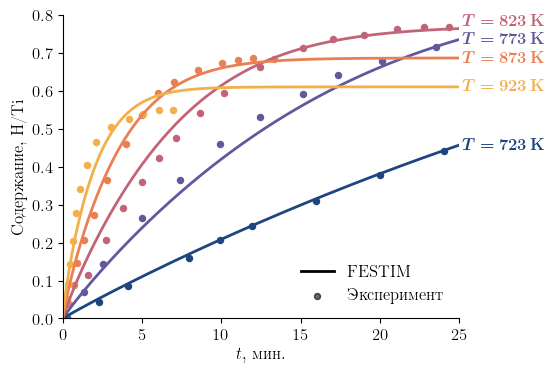

In [6]:
import matplotlib.pyplot as plt
from pypalettes import load_cmap

cmap = load_cmap("Sunset2", reverse=False)

mpl_params = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [
            r"\usepackage{siunitx}",
            r"\sisetup{detect-all}",
            r"\usepackage{amsmath}",
            r"\usepackage[utf8]{inputenc}",
            r"\usepackage[russian]{babel}",
            r"\usepackage{bm}",
        ]
    ),
    "axes.spines.right": False,
    "axes.spines.top": False,
    "font.family": "Times New Roman",
    "font.size": 12,
    "legend.frameon": False,
}

plt.rcParams.update(mpl_params)
mm2inch = 1e-1 / 2.54


def plot_inventory(ax, T0, FESTIM_data, color):
    retention = np.array(FESTIM_data[1].data) + np.array(
        FESTIM_data[0].data
    )  # half of the sample
    t = np.array(FESTIM_data.t)

    ax.plot(t / 60, retention * A / N_Ti, lw=2, ls="solid", color=color)

    exp = np.loadtxt(f"./reference_data/{T0-273}.csv", delimiter=",", skiprows=1)
    ax.scatter(exp[:, 0], exp[:, 1], s=19, color=color)

    if T0 == 823:
        y = retention[-1] * A / N_Ti + 0.02
    else:
        y = retention[-1] * A / N_Ti

    ax.text(
        25.2,
        y,
        rf"$\bm{{T={T0}}}\,\textbf{{\si{{K}}}}$",
        ha="left",
        va="center",
        color=color,
    )


fig, ax = plt.subplots(figsize=(130 * mm2inch, 100 * mm2inch))

for i, T0 in enumerate(T_list):
    plot_inventory(ax, T0, results[T0], cmap(i))

ax.plot(0, 0, color="black", lw=2, label="FESTIM")
ax.scatter(0, 0, color="black", s=19, alpha=0.6, label="Эксперимент")

ax.set_ylabel("Содержание, H/Ti")
ax.set_xlabel("$t$, мин.")
ax.set_ylim(0, 0.8)
ax.set_xlim(0, 25)
ax.legend(loc="lower right")

plt.savefig("../../../Thesis/images/val1.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

We can evaluate RMSE between simulation and experimental results. 

In [7]:
for k, T0 in enumerate(T_list):

    res = results[T0]
    retention = np.array(res[1].data) + np.array(res[0].data)  # half of the sample
    t = np.array(res.t)

    interp_ret = interp1d(t, retention * A / N_Ti, fill_value="extrapolate")

    ref = np.loadtxt(f"./reference_data/{T0-273}.csv", delimiter=",", skiprows=1)

    if k == 0:
        data_FESTIM = interp_ret(ref[:, 0] * 60)
        data_exp = ref[:, 1]
    else:
        data_FESTIM = np.concatenate([data_FESTIM, interp_ret(ref[:, 0] * 60)])
        data_exp = np.concatenate([data_exp, ref[:, 1]])

error = RMSE(data_FESTIM, data_exp)
print(f"RMSE={error:.3e}")

RMSE=2.915e-02
